In [50]:
import numpy as np
import h5py

In [51]:
# Looks for files in current directory
folder_path = '.'

# (User) Loads all the data, this file needs to be in the path defined by folder_path
data = h5py.File(pjoin(folder_path, 'cleaned_data.mat'))

In [52]:
f = h5py.File(pjoin(folder_path, 'cleaned_data.mat'),'r')
variables = f.items()

In [53]:
for var in variables:
    name = var[0]
    data = var[1]
    print (name)  # Name

name LPF_cutOff
name bandFilt
name comb
name filt_AI_mat
name freqUnit
name phase_deg
name tol


In [54]:
loop_data = f['filt_AI_mat']

In [56]:
loop_data.shape

(16384, 256, 256)

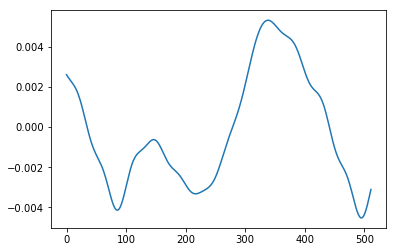

In [60]:
plt.plot(loop_data[0:512,1,1])